In [106]:
%matplotlib notebook

import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import socket
import getpass
import pandas as pd
import xml.etree.ElementTree as ET
import time

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [108]:
print(torch.__version__)

1.1.0


In [109]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [110]:
class VOCDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(800, 800)): 
        super(VOCDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        
        self.images_dir = os.path.join(root_dir, 'JPEGImages')
        self.images_idx = pd.read_csv(os.path.join(root_dir, 'ImageSets/Main' ,"%s.txt" % mode), sep=' ', header=None, error_bad_lines=False) 
        self.ann_dir    = os.path.join(root_dir, 'Annotations')
        
        self.labels_map = {'aeroplane':0,  'bicycle':1, 'bird':2,  'boat':3,      'bottle':4, 
                       'bus':5,        'car':6,      'cat':7,  'chair':8,     'cow':9,
                       'diningtable':10,'dog':11,    'horse':12,  'motorbike':13, 'person':14,
                       'pottedplant':15,'sheep':16,  'sofa':17,   'train':18,   'tvmonitor':19}

    def __len__(self):
        # Return the size of the dataset
        return len(self.images_idx)
    def __repr__(self):
        # Return the data is training set or testing set, and its image size
        return "VOCDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        # Return the preprocessed data (tensor) and labels.
        img_path = os.path.join(self.images_dir, self.images_idx.iloc[idx][0]+".jpg") 
        img = Image.open(img_path).convert('RGB')
        target, _ = self.get_obj(self.images_idx.iloc[idx][0])
        
        transform = tv.transforms.Compose([ 
            # resize the image
            tv.transforms.Resize(self.image_size), 
            # convert a PIL Image to tensor in range [0,1]
            tv.transforms.ToTensor(), 
            # normalize the tensor to [-1,1]
            #tv.transforms.Normalize((1/2,1/2,1/2),(1/2,1/2,1/2)) 
        ])
        # Transform
        img = transform(img)
        target = self.convert(target)
        
        return img, target
    
    def get_obj(self, img_name):
        
        img = {'object':[]}
        seen_labels = {}
        
        
        tree = ET.parse(os.path.join(self.ann_dir, img_name+".xml"))
     
        for elem in tree.iter():
            #print(elem.tag)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
                
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
                
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                for attr in list(elem):
                    
                    if 'name' in attr.tag:          
                        obj['name'] = attr.text
                        
                        img['object'] += [obj]  
 
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                           
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:       
                                obj['xmin'] = float(dim.text)
                            if 'ymin' in dim.tag:      
                                obj['ymin'] = float(dim.text)
                            if 'xmax' in dim.tag:           
                                obj['xmax'] = float(dim.text)
                            if 'ymax' in dim.tag:
                                obj['ymax'] = float(dim.text)
                                                                              
        return img, seen_labels
    
    def convert(self, objs):
        res = {'boxes':[],'labels':[]}
        frac_x = self.image_size[0] / objs['width']
        frac_y = self.image_size[0] / objs['height']
        
        for i in range(len(objs['object'])):
            res['labels'].append(self.labels_map[objs['object'][i]['name']])
            res['boxes'].append([objs['object'][i]['xmin']*frac_x, objs['object'][i]['ymin']*frac_y,
                                 objs['object'][i]['xmax']*frac_x,objs['object'][i]['ymax']*frac_y])
        
        res['labels'] = torch.Tensor(res['labels']).int()
        res['boxes'] = torch.Tensor(res['boxes'])
        return res
    
    

In [111]:
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
    boxes['labels'] = boxes['labels'].to('cpu').numpy()
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

In [112]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

In [113]:
x, x_target = train_set.__getitem__(1105)

In [114]:
x_target

{'boxes': tensor([[108.8000,   2.1333, 753.6000, 736.0000],
         [ 89.6000, 448.0000, 128.0000, 588.8000]]),
 'labels': tensor([ 5, 14], dtype=torch.int32)}

<IPython.core.display.Javascript object>


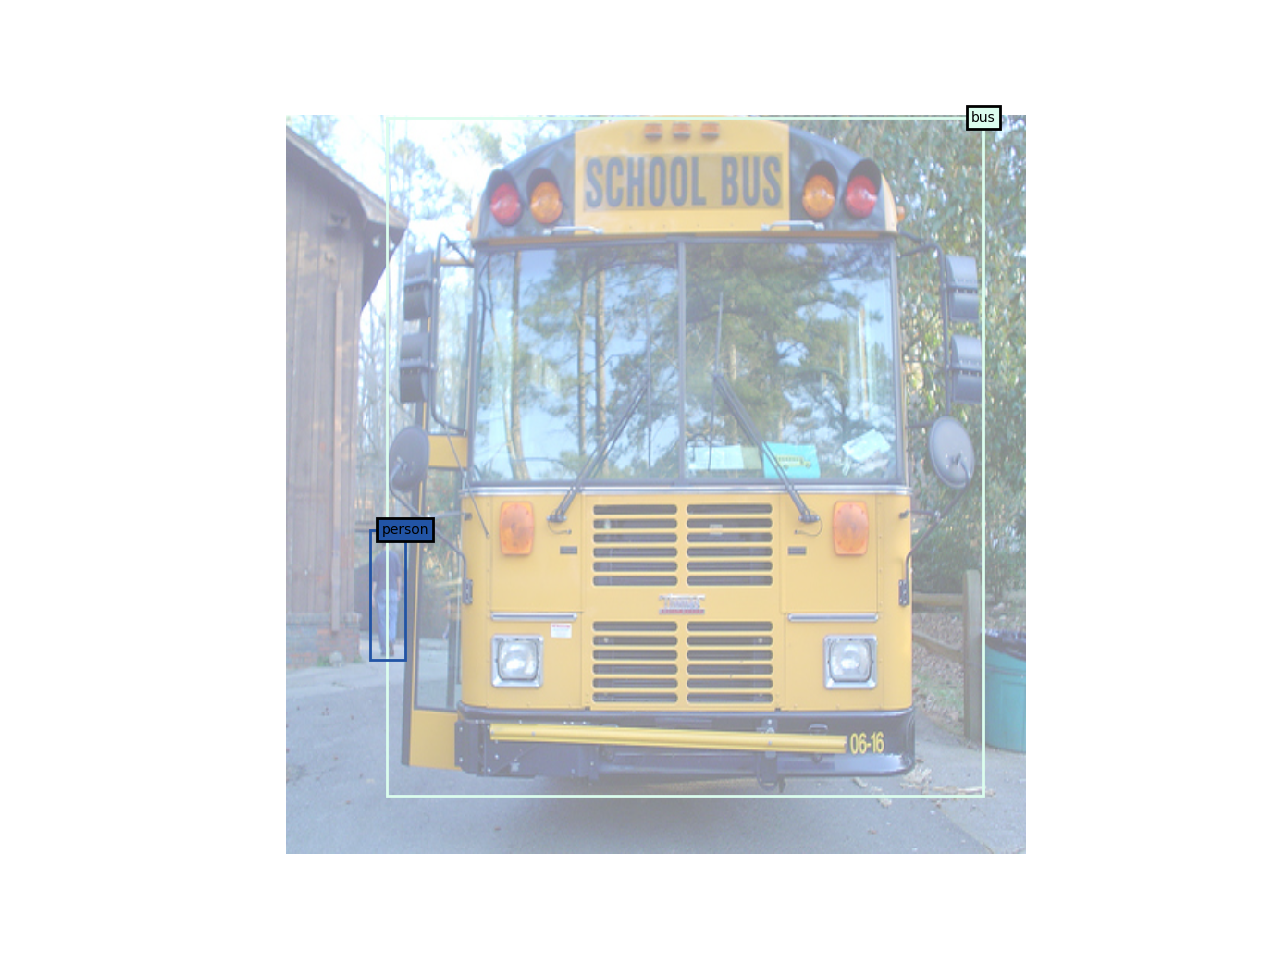

In [115]:
myimshow(x, boxes = x_target)

In [122]:
train_loader = td.DataLoader(train_set, batch_size=1, shuffle=True, pin_memory=True)
val_loader = td.DataLoader(val_set, batch_size=1, shuffle=True, pin_memory=True)

In [116]:
# load a model pre-trained 
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the last layer to fit our dataset
num_classes = 21  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features, num_classes)
model.roi_heads.box_predictor.bbox_pred =  nn.Linear(in_features, 4*num_classes)

In [119]:
model.eval()
model = model.to(device)
x = x.to(device)
model([x])

[{'boxes': tensor([[713.8757, 240.0101, 757.3565, 351.9619],
          [252.6914,  60.1282, 312.2657, 117.0614],
          [690.5379, 141.6131, 761.0881, 386.2651],
          [216.7039,  56.0984, 528.4670, 152.1172],
          [590.5214,  57.7330, 657.9614, 112.7247],
          [ 48.7368, 588.7354, 726.1394, 753.8823],
          [702.1663, 162.9688, 756.5426, 229.0114],
          [  0.0000, 314.5923, 744.2118, 748.3121],
          [  0.0000,   0.0000, 800.0000, 167.2073],
          [ 61.7916, 150.5353, 132.8041, 534.2682],
          [141.2907, 470.1201, 726.2722, 721.2227],
          [701.1423, 209.8353, 800.0000, 781.8506],
          [ 91.3157,  10.2723, 441.6432, 674.3454],
          [630.3540, 198.4283, 759.1774, 349.4405],
          [201.4871,  32.3085, 380.7749, 166.9391],
          [121.3166, 152.3955, 164.6339, 374.5030],
          [ 18.7424, 550.5422,  76.7366, 598.7942],
          [ 22.3323, 192.0391, 277.8449, 800.0000],
          [ 66.1163, 517.2619, 800.0000, 788.1750],
   

In [123]:
model.train()
for minibatch_count, (images, targets) in enumerate(train_loader, start=1):
    images = images.to(device)
    print(images.is_cuda)
    #targets = targets.to(device)
    print(images.shape)
    print([t for t in targets])
    model(images,targets)
    if minibatch_count == 1:
        break

True
torch.Size([1, 3, 800, 800])
['boxes', 'labels']


KeyError: 0

In [88]:
x

tensor([[[0.8863, 0.8902, 0.8941,  ..., 0.2706, 0.1333, 0.0431],
         [0.8549, 0.8471, 0.8353,  ..., 0.2275, 0.1176, 0.0510],
         [0.7843, 0.7490, 0.7020,  ..., 0.1255, 0.0863, 0.0667],
         ...,
         [0.3333, 0.3059, 0.2784,  ..., 0.4431, 0.4667, 0.4824],
         [0.3176, 0.2980, 0.2745,  ..., 0.4824, 0.5059, 0.5176],
         [0.3137, 0.2941, 0.2745,  ..., 0.5020, 0.5216, 0.5333]],

        [[0.9922, 0.9961, 1.0000,  ..., 0.3922, 0.2902, 0.2235],
         [0.9804, 0.9765, 0.9725,  ..., 0.3647, 0.2824, 0.2353],
         [0.9569, 0.9373, 0.9059,  ..., 0.2980, 0.2706, 0.2627],
         ...,
         [0.5098, 0.4941, 0.4745,  ..., 0.5843, 0.6078, 0.6275],
         [0.4863, 0.4863, 0.4863,  ..., 0.6196, 0.6314, 0.6431],
         [0.4745, 0.4824, 0.4902,  ..., 0.6353, 0.6431, 0.6471]],

        [[0.9647, 0.9608, 0.9569,  ..., 0.5647, 0.3961, 0.2824],
         [0.9294, 0.9176, 0.9059,  ..., 0.5137, 0.3804, 0.2902],
         [0.8471, 0.8196, 0.7882,  ..., 0.3961, 0.3373, 0.

In [73]:
model.train()
model([x], x_target)

KeyError: 0

In [29]:
def train(num_epochs, net, epoch = 0):
        net.train()
        #self.stats_manager.init()
        start_epoch = epoch
        print("Start/Continue training from epoch {}".format(start_epoch))

        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            self.stats_manager.init()
            for x, d in self.train_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                self.optimizer.zero_grad()
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                loss.backward()
                self.optimizer.step()
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), x, y, d)
            if not self.perform_validation_during_training:
                self.history.append(self.stats_manager.summarize())
            else:
                self.history.append(
                    (self.stats_manager.summarize(), self.evaluate()))
            print("Epoch {} (Time: {:.2f}s)".format(
                self.epoch, time.time() - s))
            self.save()

        print("Finish training for {} epochs".format(num_epochs))

ModuleNotFoundError: No module named 'coco_utils'

In [179]:
class Fasterrcnn_resnet50_Transfer():
    def __init__(self, num_classes, fine_tuning=False):
        super(Fasterrcnn_resnet50_Transfer, self).__init__()
        self.model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = fine_tuning
            
        cls_score_num_ftrs = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor.cls_score = nn.Linear(cls_score_num_ftrs, num_classes+1)
        
        bbox_pred_num_ftrs = self.model.roi_heads.box_predictor.bbox_pred.in_features
        self.model.roi_heads.box_predictor.bbox_pred =  nn.Linear(bbox_pred_num_ftrs, 4*(num_classes+1))
        
    def forward(self, x): 
        f = self.model(x)
        return f

In [103]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [80]:
model.eval()

Fasterrcnn_resnet50_Transfer(
  (cross_entropy): CrossEntropyLoss()
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform()
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace)
            (downsample): Sequential(
              (0): Conv2d(64

In [98]:
model = model.to(device)
x = x.to(device)
x.shape

torch.Size([3, 800, 800])

In [101]:
model.double()
x.double()

In [102]:
predictions = model([x])

RuntimeError: expected backend CUDA and dtype Double but got backend CPU and dtype Double

In [88]:
predictions[0]

{'boxes': tensor([[694.1944, 289.7036, 785.6205, 653.0170],
         [440.7126, 254.2744, 473.8892, 288.8907],
         [595.3118, 209.2947, 630.6294, 251.9214],
         [585.0803, 181.3665, 649.2815, 265.2468],
         [ 13.8698, 258.7011, 229.4585, 602.9433],
         [669.6569, 256.1098, 748.9651, 631.4413],
         [546.9425, 155.5811, 787.9915, 800.0000],
         [744.0042, 355.8398, 796.3456, 431.7448],
         [271.5854, 312.4984, 315.6399, 418.6412],
         [744.0571, 383.5904, 800.0000, 449.3448],
         [676.7697, 205.3723, 712.0314, 247.8446],
         [645.8719, 234.5465, 800.0000, 755.8052],
         [147.2887, 472.0070, 362.6475, 745.9150],
         [ 42.5648, 519.5809, 253.4495, 764.4346],
         [  0.0000, 496.8019, 214.0682, 757.3727],
         [454.0125, 259.1192, 472.0844, 287.3155],
         [513.9700, 507.9774, 727.4023, 715.6243],
         [544.9617, 300.1578, 758.1155, 562.5499],
         [ 20.7906, 155.8474, 207.1853, 440.8537],
         [178.8902, 42

In [163]:
def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(names)):

        ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],facecolor='none'))
        ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
    ax.axis('off') 
   
    return h




<IPython.core.display.Javascript object>


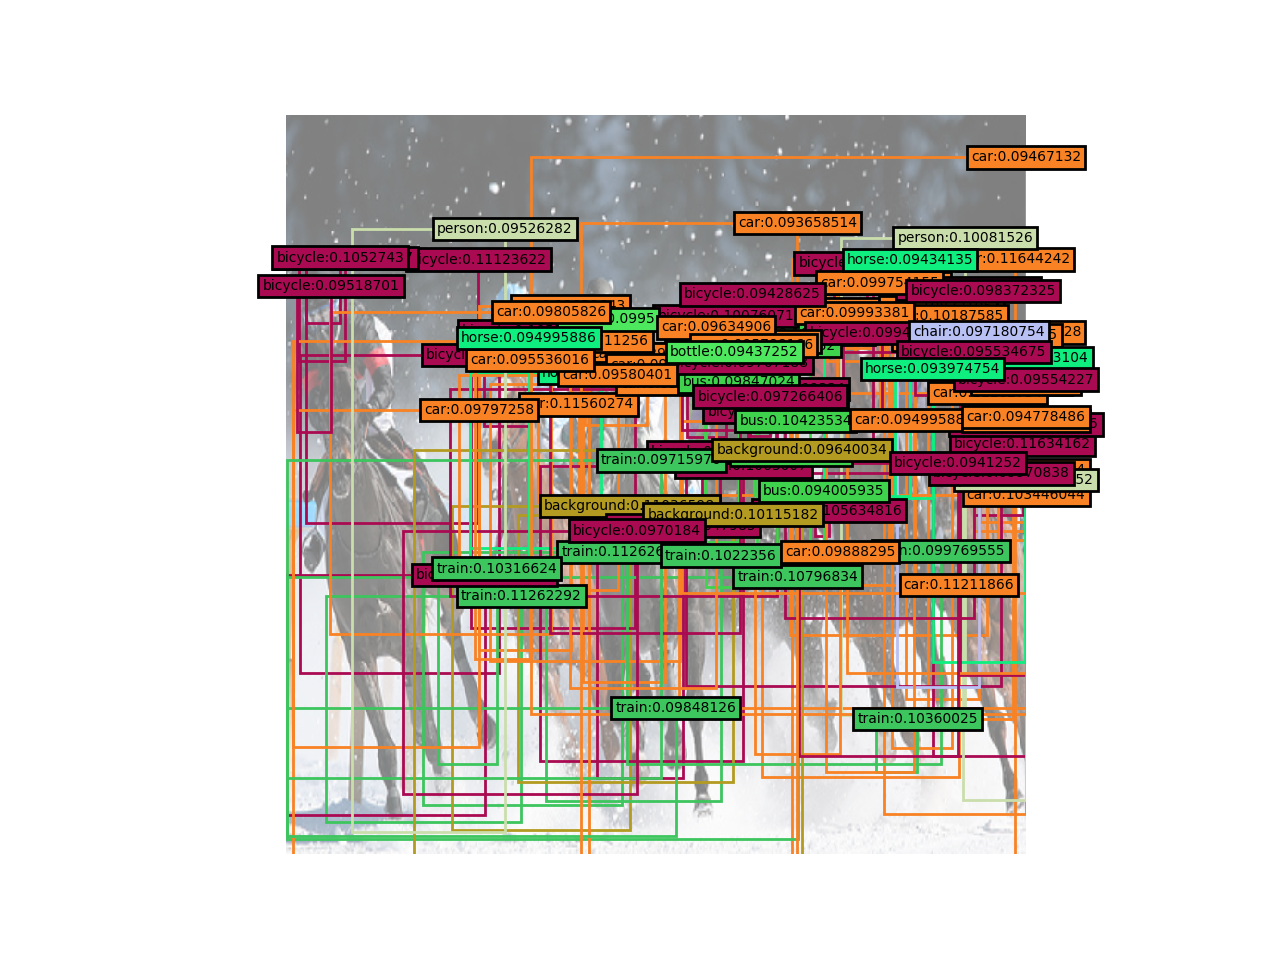

In [164]:
myimshow_score(x,predictions[0])

In [ ]:
x_objs['boxes']

In [184]:
# training
model00.train()
model00([x], torch.Tensor(x_objs['boxes']),torch.Tensor(x_objs['names']))


TypeError: forward() takes from 2 to 3 positional arguments but 4 were given

In [182]:
x_objs['boxes']

[[32.0, 228.57142857142856, 230.4, 765.2173913043478],
 [209.60000000000002, 253.41614906832297, 364.8, 740.3726708074533],
 [323.20000000000005, 245.96273291925465, 457.6, 762.7329192546583],
 [462.40000000000003, 255.9006211180124, 598.4, 725.4658385093168],
 [596.8000000000001, 218.63354037267078, 718.4000000000001, 710.5590062111801],
 [688.0, 290.6832298136646, 800.0, 762.7329192546583],
 [14.4, 163.9751552795031, 169.60000000000002, 499.3788819875776],
 [192.0, 183.85093167701862, 323.20000000000005, 496.89440993788816],
 [305.6, 176.3975155279503, 446.40000000000003, 449.68944099378876],
 [430.40000000000003, 213.66459627329192, 534.4, 439.75155279503105],
 [561.6, 161.49068322981364, 676.8000000000001, 457.1428571428571],
 [657.6, 168.944099378882, 800.0, 531.6770186335403]]

In [103]:
x_objs

{'object': [{'name': 'horse',
   'xmin': 32.0,
   'ymin': 228.57142857142856,
   'xmax': 230.4,
   'ymax': 765.2173913043478},
  {'name': 'horse',
   'xmin': 209.60000000000002,
   'ymin': 253.41614906832297,
   'xmax': 364.8,
   'ymax': 740.3726708074533},
  {'name': 'horse',
   'xmin': 323.20000000000005,
   'ymin': 245.96273291925465,
   'xmax': 457.6,
   'ymax': 762.7329192546583},
  {'name': 'horse',
   'xmin': 462.40000000000003,
   'ymin': 255.9006211180124,
   'xmax': 598.4,
   'ymax': 725.4658385093168},
  {'name': 'horse',
   'xmin': 596.8000000000001,
   'ymin': 218.63354037267078,
   'xmax': 718.4000000000001,
   'ymax': 710.5590062111801},
  {'name': 'horse',
   'xmin': 688.0,
   'ymin': 290.6832298136646,
   'xmax': 800.0,
   'ymax': 762.7329192546583},
  {'name': 'person',
   'xmin': 14.4,
   'ymin': 163.9751552795031,
   'xmax': 169.60000000000002,
   'ymax': 499.3788819875776},
  {'name': 'person',
   'xmin': 192.0,
   'ymin': 183.85093167701862,
   'xmax': 323.2000000